# Shear bias simple test 1

If we have identically zero shape noise, then we only need one galaxy to measure the shear.

A simple validation of shear bias is then to simulate sheared galaxy images with different applied shears and make the measured vs input shear plot and regression. If this doesn't work, then there's a fundamental bug. 


**Simulation procedure:**
1. Make a galaxy image with zero intrinsic ellipticity
2. Shear the image
3. Plot the shear component 1D conditional and marginal posteriors
4. Calculate the shear component marginal posterior constraints
5. Repeat steps 1-4 with different applied shears
6. Repeat steps 1-5 with different SNRs

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import galsim

In [125]:
HLR = 5.0
PSF = galsim.Kolmogorov(fwhm=0.6)
scale = 0.2
nx = ny = 256
# var = 3e-7  # Approximately SNR of 100
var = 3e-12
noise = galsim.GaussianNoise(sigma=np.sqrt(var))

In [126]:
def make_data(e1, e2, nu=0.5):
    gal = galsim.Spergel(nu, half_light_radius=HLR)
    obj = galsim.Convolve(PSF, gal)
    obj = obj.shear(galsim.Shear(e1=e1, e2=e2))
    img = obj.drawImage(nx=nx, ny=ny, scale=scale)
    img.addNoise(noise)    
    return img

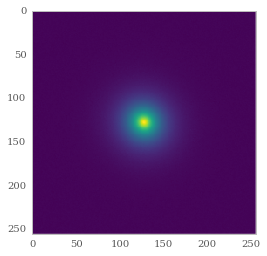

In [130]:
g2 = 0.05

img = make_data(e1=0.0, e2=g2, nu=0.5)
plt.imshow(img.array, interpolation='none', cmap=plt.cm.viridis)

In [131]:
def lnlike1(e1, e2, nu=0.5):
    gal = galsim.Spergel(nu, half_light_radius=HLR)
    obj = galsim.Convolve(PSF, gal)
    obj = obj.shear(galsim.Shear(e1=e1, e2=e2))
    model = obj.drawImage(nx=nx, ny=ny, scale=scale)
    delta = (model.array - img.array)**2
    lnnorm = - 0.5 * nx * ny * np.sqrt(var * 2 * np.pi)
    return -0.5*np.sum(delta / var) + lnnorm

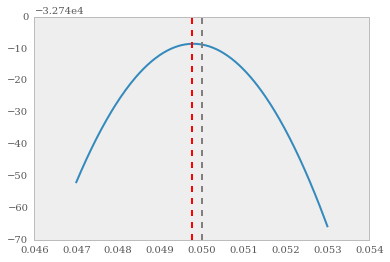

In [134]:
g = np.linspace(g2 - 0.003, g2 + 0.003, 200)

lnp = np.array([lnlike1(e1=0.0, e2=g_val, nu=0.5) for g_val in g])
plt.plot(g, lnp)
plt.axvline(g2, color='grey', linestyle='dashed')
plt.axvline(g[np.argmax(lnp)], color='red', linestyle='dashed')